### <center>Chestnut Bur Detection and Segmentation using MaskRCNN in PyTorch</center>

In [1]:
%matplotlib inline

import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, Subset, DataLoader
import torchvision
from torchvision import transforms as _transforms, tv_tensors
import torchvision.transforms.v2 as T
from cv2 import fillPoly
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
from matplotlib.patches import Polygon
import shutil
import os

from detection_pytorch import engine

##### <center> Load the image and annotation data </center>

In [2]:
# load annotations from json file here: "C:\Users\exx\Downloads\Route 9 Orchard 4.v1-test_dataset.coco-segmentation\train\_annotations.coco.json"
annos = json.load(open("C:/Users/exx/Downloads/Route 9 Orchard 4.v1-test_dataset.coco-segmentation/train/_annotations.coco.json"))

In [3]:
for key in annos.keys():
    print(annos[key])

{'year': '2024', 'version': '1', 'description': 'Exported from roboflow.com', 'contributor': '', 'url': 'https://public.roboflow.com/object-detection/undefined', 'date_created': '2024-08-13T19:46:53+00:00'}
[{'id': 1, 'url': 'https://creativecommons.org/licenses/by-nc-sa/4.0/', 'name': 'BY-NC-SA 4.0'}]
[{'id': 0, 'name': 'Chestnut-burr-CNsm', 'supercategory': 'none'}, {'id': 1, 'name': 'canopy', 'supercategory': 'Chestnut-burr-CNsm'}, {'id': 2, 'name': 'chestnut bur', 'supercategory': 'Chestnut-burr-CNsm'}]
[{'id': 0, 'license': 1, 'file_name': '107_png.rf.0890c9586fe43c53410d1f02f076ff4c.jpg', 'height': 1412, 'width': 1453, 'date_captured': '2024-08-13T19:46:53+00:00'}, {'id': 1, 'license': 1, 'file_name': '105_png.rf.4c53d3a84ad8e41bda83d406bd6327f8.jpg', 'height': 1366, 'width': 1319, 'date_captured': '2024-08-13T19:46:53+00:00'}, {'id': 2, 'license': 1, 'file_name': '101_png.rf.6ea0ba77d29d4b1cb1827ca8c3dcbb91.jpg', 'height': 1458, 'width': 1468, 'date_captured': '2024-08-13T19:46:

In [4]:
# convert the annos dict to a df, where each row is an image and the columns are the file name, the category name,
# the polygon coords, bbox, area, and iscrowd
annos_df = pd.DataFrame(annos["annotations"])
df = pd.DataFrame()
df["tree_id"] = annos_df["image_id"].apply(lambda x: annos["images"][x]["file_name"].split("_")[0])
df["file_name"] = annos_df["image_id"].apply(lambda x: annos["images"][x]["file_name"])
df["file_name"] = df["file_name"].apply(lambda x: x.split("_")[0] + ".png")
categories = [cat["name"] for cat in annos["categories"]]
df["category_name"] = annos_df["category_id"].apply(lambda x: categories[x])
df["bbox"] = annos_df["bbox"].apply(lambda x: torch.tensor(x))
df["area"] = annos_df["area"].apply(lambda x: torch.tensor(x))
df["segmentation"] = annos_df["segmentation"].apply(lambda x: torch.tensor(x))
df["iscrowd"] = annos_df["iscrowd"]

# get the file names that have chestnut burs
files_with_burs = df[df["category_name"] == "chestnut bur"]["file_name"].unique()

# filter df to keep only rows with file name in files with burs
df = df[df["file_name"].isin(files_with_burs)]

In [5]:
image_dir = "C:\\Users\\exx\\EasyIDP\\Route9_Orchard4\\Outputs\\Roboflow\\images"

image_names = df["file_name"].unique()

filtered_image_dir = "C:\\Users\\exx\\Deep Learning\\Chestnut_Bur_Instance_Segmentation\\filtered_images"
Path(filtered_image_dir).mkdir(exist_ok=True)
for image_name in image_names:
    shutil.copy(image_dir + "\\" + image_name, filtered_image_dir)

##### <center> Pre-process and transform image and annotation data </center>

##### Adapted from: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#an-instance-segmentation-model-for-pennfudan-dataset

In [6]:
def mask_fill(mask, polys, color):
    from cv2 import fillPoly
    for poly in polys:
        fillPoly(mask, [poly], color)
    return mask

In [7]:
# Custom dataset loader (PyTorch) for loading images and annotation data
class ChestnutBurSegmentation(Dataset):
    """Custom Dataset for Chestnut Bur Segmentation in UAV Images"""

    def __init__(self, image_dir, df, transform = None):
        self.image_dir = image_dir
        self.df = df
        self.transform = transform
        self.unique_tree_ids = self.df["tree_id"].unique()

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        tree_id = self.unique_tree_ids[idx]

        row = self.df[self.df["tree_id"] == tree_id].iloc[0]

        image_file = Path(self.image_dir) / row["file_name"]

        image = tv_tensors.Image(Image.open(image_file))

        height, width = image.shape[-2:]

        canopy_poly = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "canopy")]["segmentation"].values
        bur_poly = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "chestnut bur")]["segmentation"].values

        canopy_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in canopy_poly]
        bur_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in bur_poly]

        # get canopy_bbox coords [xmin, ymin, xmax, ymax]
        xmin, ymin, xmax, ymax = min([poly[:, 0].min() for poly in canopy_poly]), min([poly[:, 1].min() for poly in canopy_poly]), max([poly[:, 0].max() for poly in canopy_poly]), max([poly[:, 1].max() for poly in canopy_poly])


        canopy_mask = np.zeros((height, width), dtype=np.uint8)
        canopy_mask = mask_fill(canopy_mask, canopy_poly, 1)

        bur_masks = []
        # One mask per bur. Store each bur mask in a list to stack later. 
        for poly in bur_poly:
            bur_mask = np.zeros((height, width), dtype=np.uint8)
            bur_mask = mask_fill(bur_mask, [poly], 2)
            bur_masks.append(bur_mask)

        background_mask = np.zeros((height, width, 1), dtype=np.uint8)
        bur_masks_stacked = np.stack(bur_masks, axis=-1)
        mask_image = np.concatenate([background_mask, bur_masks_stacked], axis=-1).transpose(2, 0, 1)
        labels = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "chestnut bur")]["category_name"].values
        labels = [categories.index(label) for label in labels]
        bboxes = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "chestnut bur")]["bbox"].values
        bboxes = [torch.tensor([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], dtype = torch.float32) for bbox in bboxes] # convert to xyxy format
        bboxes = torch.stack([bbox for bbox in bboxes], dim=0) # (n_objects, 4)
        area = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "chestnut bur")]["area"].values
        iscrowd = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "chestnut bur")]["iscrowd"].values

        # fill image background (outside of tree canopy)
        image = image * np.array(canopy_mask).astype(np.uint8)

        # print pre-transform image and mask shapes
        print(f'Image shape: {image.shape}')
        print(f'Mask shape: {mask_image.shape}')
        print()

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(bboxes, format=tv_tensors.BoundingBoxFormat.XYXY, canvas_size=(height, width)) 
        target["labels"] = torch.as_tensor(labels, dtype = torch.int64) # (n_objects)
        target["image_id"] = int(tree_id)
        target["area"] = torch.stack([a.clone().detach().float() for a in area], dim=0) # (n_objects)
        target["iscrowd"] = torch.stack([torch.tensor(ic, dtype = torch.int64) for ic in iscrowd], dim=0) # (n_objects)

        image = T.Compose([T.ToDtype(torch.float32, scale=True),
                           T.ColorJitter(), 
                           T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])(image)
        
        image_and_mask = torch.cat((image, torch.tensor(mask_image, dtype=torch.float32)), dim=0)

        print(f'Image_and_mask shape after stacking: {image_and_mask.shape}')
        print()

        # crop image_and_mask to xmin, ymin, xmax, ymax
        image_and_mask = image_and_mask[:, (int(ymin)-50):(int(ymax)+50), (int(xmin)-50):(int(xmax)+50)] # pad by 50 in each direction

        print(f'Image_and_mask shape after cropping: {image_and_mask.shape}')
        print()
            
        if self.transform is not None:
            image_and_mask, target = self.transform(image_and_mask, target)

            print(f'Image_and_mask shape after transforming: {image_and_mask.shape}')
            print()
        
        image = image_and_mask[:image.shape[0], :, :] # slice out the transformed image
        mask_image = image_and_mask[image.shape[0]:, :].clone().detach().to(torch.uint8) # slice out the transformed mask

        # print post-transform image and mask shapes
        print(f'Final image shape: {image.shape}')
        print(f'Final mask shape: {mask_image.shape}')
        print()

        target["masks"] = mask_image

        return image, target
        
    def collate_fn(batch):
        return tuple(zip(*batch))

    def __len__(self):
        return len(self.unique_tree_ids)

In [18]:
# define transforms for the dataset
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.Resize((448, 448), antialias = True)) # no maintain aspect ratio
        transforms.append(T.RandomHorizontalFlip(0.5))
    else:
        transforms.append(T.Resize((448, 448), antialias = True)) # no maintain aspect ratio
    transforms.append(T.ClampBoundingBoxes())
    transforms.append(T.SanitizeBoundingBoxes())

    return T.Compose(transforms)

In [19]:
sample_ds = ChestnutBurSegmentation(filtered_image_dir, df, get_transform(train = True))
sample_dl = DataLoader(sample_ds, batch_size = 24, shuffle = True, collate_fn = ChestnutBurSegmentation.collate_fn)

In [20]:
images, targets = next(iter(sample_dl))
images = [img for img in images]
targets = [{k: v for k, v in target.items()} for target in targets]

Image shape: torch.Size([3, 2025, 2098])
Mask shape: (22, 2025, 2098)

Image_and_mask shape after stacking: torch.Size([25, 2025, 2098])

Image_and_mask shape after cropping: torch.Size([25, 1217, 1284])

Image_and_mask shape after transforming: torch.Size([25, 448, 448])

Final image shape: torch.Size([3, 448, 448])
Final mask shape: torch.Size([22, 448, 448])



##### <center> Plot sample transformed images, targets, and masks </center>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117905..2.14018].


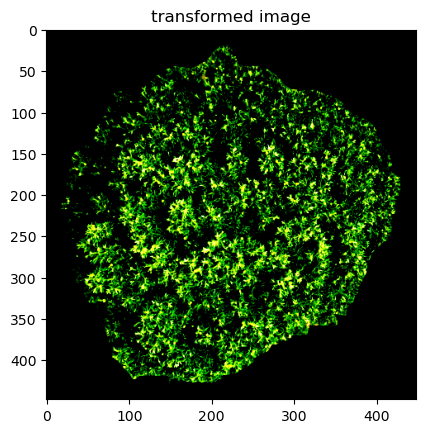

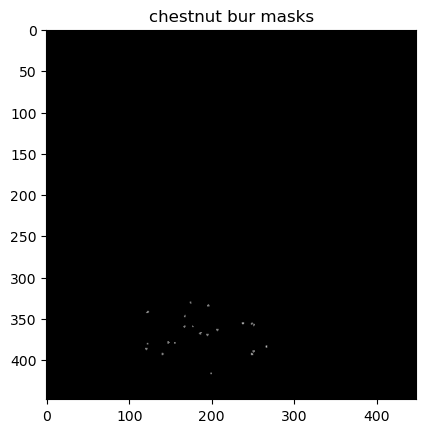

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117905..2.14018].


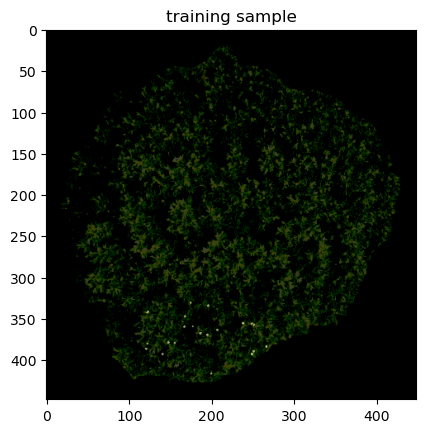

In [21]:
%matplotlib inline
tree_ids = [target["image_id"] for target in targets]

image = images[tree_ids.index(11)].permute(1, 2, 0) if 11 in tree_ids else images[0].permute(1, 2, 0)
mask = targets[tree_ids.index(11)]["masks"].permute(1, 2, 0) if 11 in tree_ids else targets[0]["masks"].permute(1, 2, 0)

plt.imshow(image)
plt.title("transformed image")
plt.show()

plt.imshow(mask.sum(axis=2), cmap="gray")
plt.title("chestnut bur masks")
plt.show()

# plot mask on image
plt.imshow(image)
plt.imshow(mask.sum(axis=2), cmap='gray', alpha=0.75)
plt.title("training sample")
plt.show()

##### <center> Construct MaskRCNN Model </center>

In [12]:
def get_instance_segmentation_model(num_classes):
    # Load a Mask R-CNN instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(
        weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT,
        weights_backbone=torchvision.models.ResNet50_Weights.DEFAULT
    )

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one to reflect the number of classes
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [13]:
print(get_instance_segmentation_model(2))

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

##### <center> Tune model hyperparameters using bayesian optimization algo and hyperband scheduler </center>

##### adapted from: https://docs.ray.io/en/latest/tune/examples/bohb_example.html

In [14]:
# Bayesian Optimization HyperBand (BOHB) with HyperBand scheduler
# # https://proceedings.mlr.press/v80/falkner18a.html

import tempfile
import time
from pathlib import Path

import ray
from ray import train, tune
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB

import ConfigSpace as CS

In [15]:
# store indices in random order list for subsetting later
indices = torch.randperm(len(sample_ds)).tolist()

In [25]:
def load_data(image_dir = filtered_image_dir, df = df): 
    train_ds = ChestnutBurSegmentation(image_dir, df, get_transform(train = True))
    val_ds = ChestnutBurSegmentation(image_dir, df, get_transform(train = False))
    return train_ds, val_ds


def train_ChestnutBurSegmentation(search_space, indices):
    model = get_instance_segmentation_model(num_classes = 2) # background, chestnut bur
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model) # train on multiple gpus if available
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, 
                                lr = search_space["lr"], 
                                momentum = search_space["momentum"], 
                                weight_decay = search_space["weight_decay"])
    
    # construct a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                                   step_size = search_space["step_size"], 
                                                   gamma = search_space["gamma"])
    
    # load existing checkpoint if available
    if train.get_checkpoint():
        loaded_checkpoint = train.get_checkpoint()
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(
                os.path.join(loaded_checkpoint_dir, "checkpoint.pt")
            )
            model.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)
    else:
        start_epoch = 0

    # load data
    train_ds, val_ds = load_data()
    
    train_ds = Subset(train_ds, indices[:-int(len(train_ds)*0.2)]) # first 80% of dataset for training
    val_ds = Subset(val_ds, indices[-int(len(train_ds)*0.2):-int(len(train_ds)*0.05)]) # next 15% of dataset for validation

    train_dl = DataLoader(train_ds, batch_size = search_space["batch_size"], shuffle = True, collate_fn = ChestnutBurSegmentation.collate_fn, num_workers=0, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size = search_space["batch_size"], shuffle = False, collate_fn = ChestnutBurSegmentation.collate_fn, num_workers=0, pin_memory=True)

    # Main training function
    for epoch in range(start_epoch, search_space["epochs"]):
        # train for one epoch, printing every 10 iterations
        train_logger = engine.train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        val_metrics = engine.evaluate(model, val_dl, device=device)

        # save checkpoint
         # Here we save a checkpoint. It is automatically registered with Ray Tune
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
            torch.save(
                (model.state_dict(), optimizer.state_dict()), path
            )
            checkpoint = train.Checkpoint.from_directory(temp_checkpoint_dir)
            train.report(
                {"train_loss": train_logger.loss.value, # metric_logger object,
                "mAP_50": val_metrics.coco_eval['bbox'].stats[1], # coco evaluator object (mAP@50)
                "mAR_100": val_metrics.coco_eval['bbox'].stats[8], # coco evaluator object (mAR@100)
                "epoch": epoch}, 
                checkpoint = checkpoint
            )
    
    print("Tuning Trial Complete!")


def test_best_model(best_result, indices):
    best_model = get_instance_segmentation_model(num_classes = 2) # background, chestnut bur

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_model.to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, _ = torch.load(checkpoint_path)
    best_model.load_state_dict(model_state)

    _, test_ds = load_data()
    test_ds = Subset(test_ds, indices[-int(len(test_ds)*0.05):]) # last 5% of dataset for testing
    test_dl = DataLoader(test_ds, batch_size = 1, shuffle = False, collate_fn = ChestnutBurSegmentation.collate_fn, num_workers=0, pin_memory=True)

    test_results = engine.evaluate(best_model, test_dl, device=device)

    print(f'Best trial test set mAP_50: {test_results.coco_eval["bbox"].stats[1]} and mAR_100: {test_results.coco_eval["bbox"].stats[8]}')


def trial_dirname_creator(trial):
    return f"train_MAVdroneDataset_{trial.trial_id}"

In [31]:
torch.cuda.empty_cache()

def main(num_samples, indices):
    search_space = CS.ConfigurationSpace()
    search_space.add_hyperparameter(
        CS.Constant("epochs", 2)
    )
    search_space.add_hyperparameter(
        CS.UniformFloatHyperparameter("lr", lower=0.00009, upper=0.1)
    )
    search_space.add_hyperparameter(
        CS.UniformFloatHyperparameter("momentum", lower=0.00001, upper=0.99)
    )
    search_space.add_hyperparameter(
        CS.UniformFloatHyperparameter("weight_decay", lower=0.00001, upper=0.99)
    )
    search_space.add_hyperparameter(
        CS.UniformIntegerHyperparameter("step_size", lower=1, upper=15)
    )
    search_space.add_hyperparameter(
        CS.UniformFloatHyperparameter("gamma", lower=0.00001, upper=0.99)
    )
    search_space.add_hyperparameter(
        CS.CategoricalHyperparameter("batch_size", choices=[2, 4, 8, 16, 32])
    )

    algo = TuneBOHB(
        space=search_space,
        metric="mAP_50",
        mode="max",
    )
    algo = tune.search.ConcurrencyLimiter(algo, max_concurrent=4)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=search_space.get_hyperparameter("epochs").default_value,
        reduction_factor=4,
        stop_last_trials=False,
    )

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_ChestnutBurSegmentation, indices=indices),
            resources = {"cpu": 12, "gpu": 0.25},
        ),
        run_config=train.RunConfig(
            name="bohb_exp",
            storage_path='C:/Users/exx/Documents/GitHub/Savanna-Institute/Drone-based_Chestnut_Detection/ray_results',
            stop={"training_iteration": search_space["epochs"]}
        ),
        tune_config = tune.TuneConfig(
            metric = "mAP_50",
            mode = "max",
            search_alg = algo,
            scheduler = scheduler,
            num_samples = num_samples,
            time_budget_s=600000,
            trial_dirname_creator=trial_dirname_creator
        ),
    )

    results = tuner.fit()

    best_result = results.get_best_result("mAP_50", "max")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final training loss: {}".format(best_result.metrics["train_loss"]))
    print("Best trial final validation mAP_50: {}".format(best_result.metrics["mAP_50"]))
    print("Best trial final validation mAR_100: {}".format(best_result.metrics["mAR_100"]))

    test_best_model(best_result, indices)

    return best_result

if __name__ == "__main__": 
    best_trial = main(num_samples = 10, indices = indices)

2024-09-17 14:59:45,563	ERROR tune_controller.py:1331 -- Trial task failed for trial train_ChestnutBurSegmentation_8ed8de06
Traceback (most recent call last):
  File "c:\Users\exx\.conda\envs\bohb\lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "c:\Users\exx\.conda\envs\bohb\lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "c:\Users\exx\.conda\envs\bohb\lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\exx\.conda\envs\bohb\lib\site-packages\ray\_private\worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "c:\Users\exx\.conda\envs\bohb\lib\site-packages\ray\_private\worker.py", line 871, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.t

RuntimeError: No best trial found for the given metric: mAP_50. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

##### <center> Train the model using tuned hyperparameters </center>

In [ ]:
# # train on the GPU or on the CPU, if a GPU is not available
# device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# num_classes = 2 # (background = 0, chestnut bur = 1)

# # use our dataset and defined transformations
# train_ds = ChestnutBurSegmentation(filtered_image_dir, df, get_transform(train = True))
# val_ds = ChestnutBurSegmentation(filtered_image_dir, df, get_transform(train = False))

# train_ds = Subset(train_ds, indices[:-int(len(train_ds)*0.2)]) # first 80% of dataset for training
# val_ds = Subset(val_ds, indices[-int(len(train_ds)*0.2):-int(len(train_ds)*0.05)]) # next 15% of dataset for validation

# train_dl = DataLoader(train_ds, batch_size = 8, shuffle = True, collate_fn = ChestnutBurSegmentation.collate_fn)
# valid_dl = DataLoader(val_ds, batch_size = 1, shuffle = False, collate_fn = ChestnutBurSegmentation.collate_fn)

# # get the model using our helper function
# model = get_instance_segmentation_model(num_classes)

# # move model to the right device
# model.to(device)

# # construct an optimizer
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(
#     params,
#     lr=0.005,
#     momentum=0.9,
#     weight_decay=0.0005
# )

# # and a learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer,
#     step_size=3,
#     gamma=0.1
# )

# num_epochs = 2

# for epoch in range(num_epochs):
#     # train for one epoch, printing every 10 iterations
#     engine.train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=10)
#     # update the learning rate
#     lr_scheduler.step()
#     # evaluate on the test dataset
#     engine.evaluate(model, valid_dl, device=device)

# print("That's it!")